<a href="https://colab.research.google.com/github/mateuszbarnacki/SSN-Proj/blob/main/SSN_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importy**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
!pip install tensorflow-addons==0.10.0
import tensorflow_addons
from tensorflow_addons.layers import MultiHeadAttention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


**Przygotowanie danych wejściowych**

In [2]:
data = pd.read_csv("COVID-19 w Polsce - Wzrost.csv", header=None)
data = data.values[2:-1,1]
data = np.array([x[2:] for x in data]).astype(int)

# !pip install tensorflow_datasets
# !pip install -U 'tensorflow-text==2.8.*'

train_data, val_data = data[:700], data[700:]

def linear(x):
  return x

**Architektura modelu**

In [3]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
        self.k = kernel_size
    
    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name='wb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        self.bb = self.add_weight(name='bb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        # periodic
        self.wa = self.add_weight(name='wa',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        self.ba = self.add_weight(name='ba',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp)

        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1]*(self.k+1)))
        return ret
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*(self.k + 1))

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_dense1 = keras.layers.Dense(64, activation='sigmoid')
        self.ff_dense2 = keras.layers.Dense(1, activation=linear)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)

        x = self.ff_conv1(x)
        x = self.ff_conv2(x)
        x = self.ff_dropout(x)
        x = self.ff_norm(inputs + x)

        x = self.ff_dense1(x)
        x = self.ff_dense2(x)

        return x

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', time2vec_dim=1, num_heads=2, head_size=128, ff_dim=None, num_layers=1, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      self.time2vec = Time2Vec(kernel_size=time2vec_dim)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]

        
    def call(self, inputs):
        time_embedding = keras.layers.TimeDistributed(self.time2vec)(inputs) 

        x = K.concatenate([inputs, time_embedding], -1) 

        for attention_layer in self.attention_layers:
            x = attention_layer(x) 

        return K.reshape(x, (-1, x.shape[1] * x.shape[2]))

**Przygotowanie danych z uwzględnieniem ilości dni po jakich następuje predykcja przypadków choroby**

In [4]:
def prepare_X_y(data):
  X_data = []
  y_data = []
  for i in range(len(data)-NR_DAYS):
    X = []
    for j in range(NR_DAYS):
      X.append(data[i+j] / MAX_DATA)
    X_data.append(np.array(X))
    y_data.append(data[i+NR_DAYS] / MAX_DATA)

  X_data = np.array(X_data).reshape(len(X_data),NR_DAYS,1).astype(float)
  y_data = np.array(y_data).reshape(len(y_data),1,1).astype(float)

  return X_data, y_data

**Funkcje pomocnicze do analizy danych**

In [5]:
def prepare_preds(X):
  y_preds = []
  for x in X:
    X_pred = np.array(x).reshape(1,NR_DAYS,1).astype(float)
    y_pred = model.predict(X_pred) * MAX_DATA
    y_preds.append(y_pred[0][-3])
  return y_preds

def draw_predictions(nr_epochs, y_test, y_preds, title, figure_name):
    epochs = np.arange(nr_epochs)
    plt.figure(figsize=(12,4))

    plt.plot(epochs, y_test, "r")
    plt.plot(epochs, y_preds, "g")
    
    plt.ylabel("Ilość przypadków")
    plt.xlabel('Czas')
    plt.legend(['true', 'pred'], loc='best')
    plt.title("Przewidywania liczby przypadków dla danych " + title)
     
    plt.savefig(figure_name)
    plt.show()

**Funkcje miary błędu**

In [6]:
def det_coeff(y_true, y_pred):
  SS_res = K.sum(K.square(y_true - y_pred))
  SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
  return (1. - SS_res/(SS_tot + K.epsilon()))

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(y_true * y_pred))
  possible_positives = K.sum(K.round(y_true))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def specificity_m(y_true, y_pred):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

def accuracy_m(y_true, y_pred):
  correct_preds = 0
  for i in range(len(y_pred)):
    if y_true[i] == y_pred[i]:
      correct_preds = correct_preds + 1
  return correct_preds / len(y_pred)

def idx_of_agreement(y_true, y_pred):
  up = K.sum(K.square(y_true - y_pred))
  down = K.sum(K.square(K.abs(y_pred - K.mean(y_true)) + (K.abs(y_true - K.mean(y_true)))))
  return (1. - up / (down + K.epsilon()))

def mean_squared_error(y_true, y_pred):
  return K.mean(K.square(y_pred - y_true), axis=0)

def mean_absolute_error(y_true, y_pred):
  return K.mean(K.abs(y_pred - y_true), axis=0)

**Normalizacja danych oraz ustalenie ilości dni, na podstawie której zostanie dokonana predykcja ilości przypadków**

In [7]:
MAX_DATA = np.max(data)
NR_DAYS = 10

**Działanie modelu przy użyciu odgórnego podziału danych na uczące i testujące**

Rozmiar danych uczących: 700.

Rozmiar danych testowych: 39.

Epoch 1/50
22/22 [==============================] - 2s 95ms/step - loss: 0.0960 - val_loss: 0.0344
Epoch 2/50
22/22 [==============================] - 2s 88ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 3/50
22/22 [==============================] - 2s 88ms/step - loss: 0.0087 - val_loss: 0.0129
Epoch 4/50
22/22 [==============================] - 2s 91ms/step - loss: 0.0075 - val_loss: 0.0137
Epoch 5/50
22/22 [==============================] - 2s 89ms/step - loss: 0.0071 - val_loss: 0.0129
Epoch 6/50
22/22 [==============================] - 2s 86ms/step - loss: 0.0067 - val_loss: 0.0120
Epoch 7/50
22/22 [==============================] - 2s 84ms/step - loss: 0.0065 - val_loss: 0.0144
Epoch 8/50
22/22 [==============================] - 2s 87ms/step - loss: 0.0062 - val_loss: 0.0122
Epoch 9/50
22/22 [==============================] - 2s 84ms/step - loss: 0.0061 - val_loss: 0.0107
Epoch 10/50
22/22 [==============================] - 2s 84ms/step - loss: 0.0059 - val_loss: 0.0117
Epoch 11/

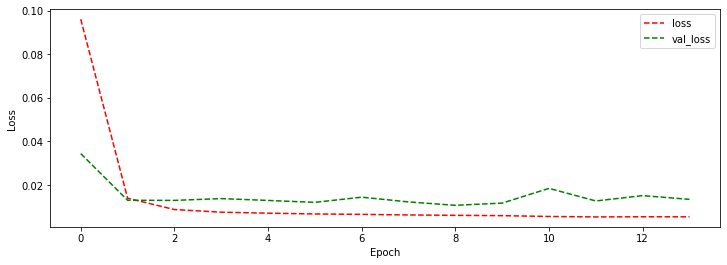

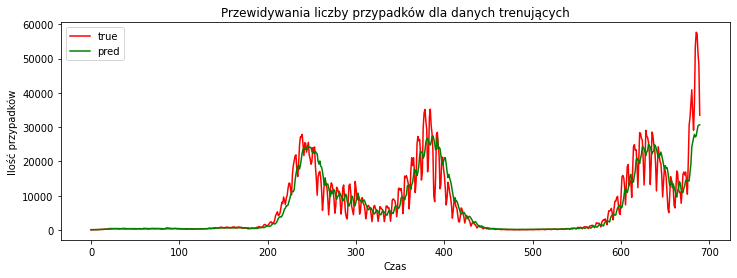

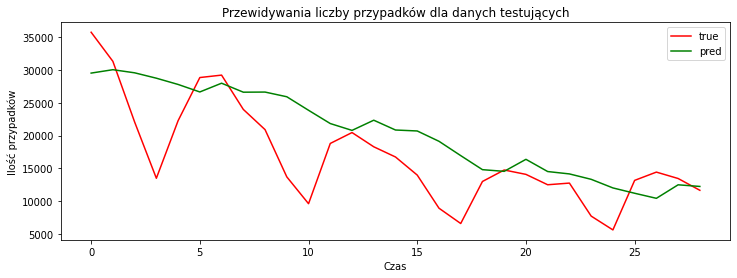

Błąd średniokwadratowy: 458449120.0
Średni błąd bezwzględny: 20410.602
Coefficient of determination: 0.2653607
Index of agreement: 0.7980475
Specyficzność: 0.6607255
Czułość: 0.0


In [13]:
X_train, y_train = prepare_X_y(train_data)

X_test, y_test = prepare_X_y(val_data)

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], "r--")
plt.plot(history.history['val_loss'], "g--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.savefig('divided_loss.png')
plt.show()

y_preds = prepare_preds(X_train)
draw_predictions(len(y_preds), y_train.reshape(len(y_preds)) * MAX_DATA, y_preds, "trenujących", "divided_train.png")
y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących", "divided_test.png")

y = np.reshape(y_test, len(y_test))
mse = mean_squared_error(K.constant(y), K.constant(y_preds))
mae = mean_absolute_error(K.constant(y), K.constant(y_preds))
print('Błąd średniokwadratowy: ' + str(K.get_value(mse)))
print('Średni błąd bezwzględny: ' + str(K.get_value(mae)))
y_preds = y_preds / MAX_DATA
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
spec = specificity_m(K.constant(y), K.constant(y_preds)) 
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Specyficzność: ' + str(K.get_value(spec)))
print('Czułość: ' + str(K.get_value(recall)))

**Podział danych za pomocą Time Series Split**

**Ilość podziałów: 5**

Epoch 1/50
18/18 [==============================] - 2s 96ms/step - loss: 0.0228 - val_loss: 0.0616
Epoch 2/50
18/18 [==============================] - 2s 91ms/step - loss: 0.0107 - val_loss: 0.0479
Epoch 3/50
18/18 [==============================] - 2s 106ms/step - loss: 0.0058 - val_loss: 0.0384
Epoch 4/50
18/18 [==============================] - 2s 101ms/step - loss: 0.0041 - val_loss: 0.0313
Epoch 5/50
18/18 [==============================] - 2s 94ms/step - loss: 0.0035 - val_loss: 0.0275
Epoch 6/50
18/18 [==============================] - 3s 161ms/step - loss: 0.0032 - val_loss: 0.0290
Epoch 7/50
18/18 [==============================] - 2s 133ms/step - loss: 0.0031 - val_loss: 0.0256
Epoch 8/50
18/18 [==============================] - 2s 106ms/step - loss: 0.0032 - val_loss: 0.0254
Epoch 9/50
18/18 [==============================] - 2s 93ms/step - loss: 0.0031 - val_loss: 0.0258
Epoch 10/50
18/18 [==============================] - 2s 133ms/step - loss: 0.0030 - val_loss: 0.0256
Epo

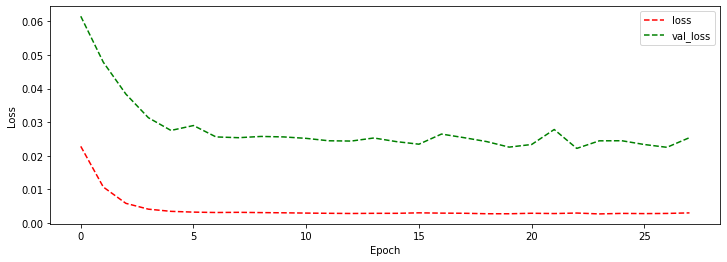

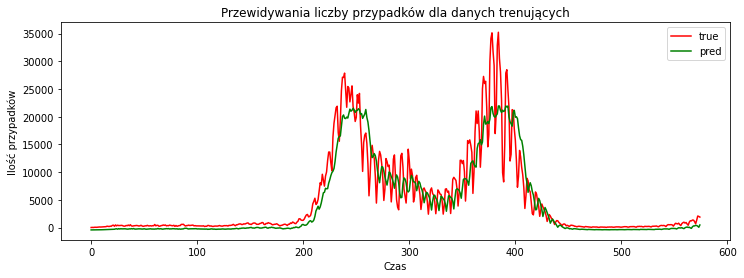

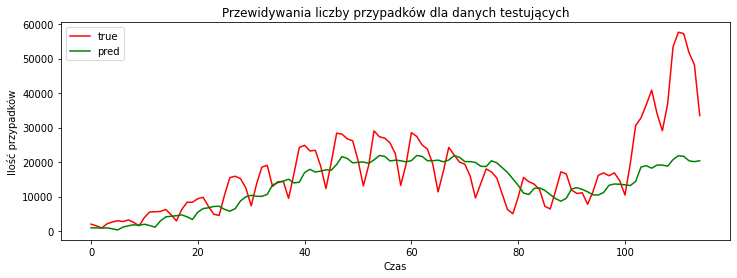

Błąd średniokwadratowy: 225812580.0
Średni błąd bezwzględny: 13388.509
Coefficient of determination: 0.38808316
Index of agreement: 0.7330622
Specyficzność: 0.79235595
Czułość: 0.0


In [9]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=5)
#print(tscv)

for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], "r--")
plt.plot(history.history['val_loss'], "g--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.savefig('time_series_5_loss.png')
plt.show()

y_preds = prepare_preds(X_train)
draw_predictions(len(y_preds), y_train.reshape(len(y_preds)) * MAX_DATA, y_preds, "trenujących", "time_series_5_train.png")
y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących", "time_series_5_test.png")

y = np.reshape(y_test, len(y_test))
mse = mean_squared_error(K.constant(y), K.constant(y_preds))
mae = mean_absolute_error(K.constant(y), K.constant(y_preds))
print('Błąd średniokwadratowy: ' + str(K.get_value(mse)))
print('Średni błąd bezwzględny: ' + str(K.get_value(mae)))
y_preds = y_preds / MAX_DATA
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
spec = specificity_m(K.constant(y), K.constant(y_preds)) 
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Specyficzność: ' + str(K.get_value(spec)))
print('Czułość: ' + str(K.get_value(recall)))

**Ilość podziałów: 10**

Epoch 1/50
20/20 [==============================] - 2s 90ms/step - loss: 0.1220 - val_loss: 0.0968
Epoch 2/50
20/20 [==============================] - 2s 88ms/step - loss: 0.0220 - val_loss: 0.1160
Epoch 3/50
20/20 [==============================] - 2s 91ms/step - loss: 0.0152 - val_loss: 0.0996
Epoch 4/50
20/20 [==============================] - 2s 87ms/step - loss: 0.0130 - val_loss: 0.1005
Epoch 5/50
20/20 [==============================] - 2s 90ms/step - loss: 0.0109 - val_loss: 0.0777
Epoch 6/50
20/20 [==============================] - 2s 86ms/step - loss: 0.0070 - val_loss: 0.0605
Epoch 7/50
20/20 [==============================] - 2s 90ms/step - loss: 0.0038 - val_loss: 0.0490
Epoch 8/50
20/20 [==============================] - 2s 86ms/step - loss: 0.0032 - val_loss: 0.0436
Epoch 9/50
20/20 [==============================] - 2s 94ms/step - loss: 0.0030 - val_loss: 0.0404
Epoch 10/50
20/20 [==============================] - 2s 88ms/step - loss: 0.0030 - val_loss: 0.0408
Epoch 11/

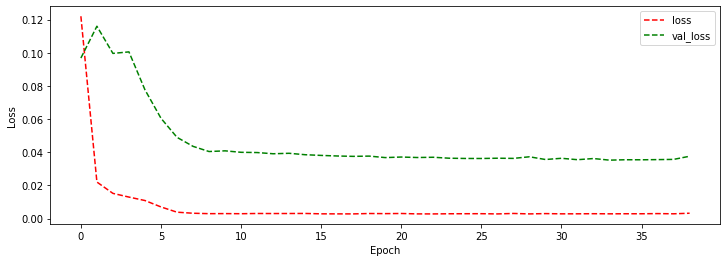

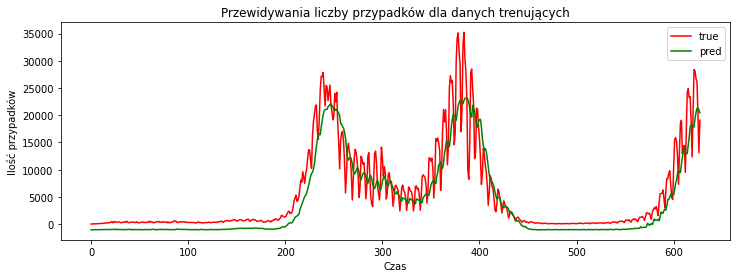

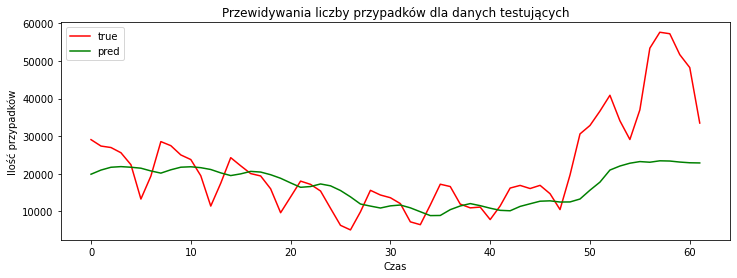

Błąd średniokwadratowy: 309503600.0
Średni błąd bezwzględny: 16921.658
Coefficient of determination: 0.21615851
Index of agreement: 0.5876229
Specyficzność: 0.72590536
Czułość: 0.0


In [10]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=10)
#print(tscv)

for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], "r--")
plt.plot(history.history['val_loss'], "g--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.savefig('time_series_10_loss.png')
plt.show()

y_preds = prepare_preds(X_train)
draw_predictions(len(y_preds), y_train.reshape(len(y_preds)) * MAX_DATA, y_preds, "trenujących", "time_series_10_train.png")
y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących", "time_series_10_test.png")

y = np.reshape(y_test, len(y_test))
mse = mean_squared_error(K.constant(y), K.constant(y_preds))
mae = mean_absolute_error(K.constant(y), K.constant(y_preds))
print('Błąd średniokwadratowy: ' + str(K.get_value(mse)))
print('Średni błąd bezwzględny: ' + str(K.get_value(mae)))
y_preds = y_preds / MAX_DATA
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
spec = specificity_m(K.constant(y), K.constant(y_preds)) 
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Specyficzność: ' + str(K.get_value(spec)))
print('Czułość: ' + str(K.get_value(recall)))

**Ilość podziałów: 8**

Epoch 1/50
20/20 [==============================] - 2s 92ms/step - loss: 0.0648 - val_loss: 0.1797
Epoch 2/50
20/20 [==============================] - 2s 89ms/step - loss: 0.0197 - val_loss: 0.0854
Epoch 3/50
20/20 [==============================] - 2s 88ms/step - loss: 0.0115 - val_loss: 0.0695
Epoch 4/50
20/20 [==============================] - 2s 90ms/step - loss: 0.0050 - val_loss: 0.0528
Epoch 5/50
20/20 [==============================] - 2s 88ms/step - loss: 0.0038 - val_loss: 0.0412
Epoch 6/50
20/20 [==============================] - 2s 99ms/step - loss: 0.0030 - val_loss: 0.0346
Epoch 7/50
20/20 [==============================] - 2s 90ms/step - loss: 0.0029 - val_loss: 0.0339
Epoch 8/50
20/20 [==============================] - 2s 87ms/step - loss: 0.0028 - val_loss: 0.0323
Epoch 9/50
20/20 [==============================] - 2s 88ms/step - loss: 0.0028 - val_loss: 0.0323
Epoch 10/50
20/20 [==============================] - 2s 89ms/step - loss: 0.0028 - val_loss: 0.0308
Epoch 11/

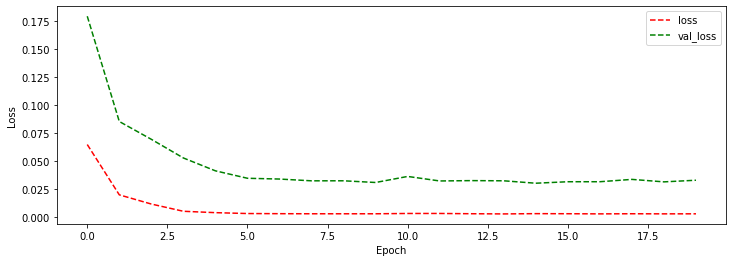

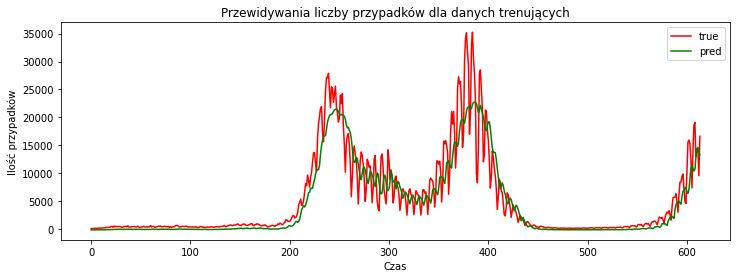

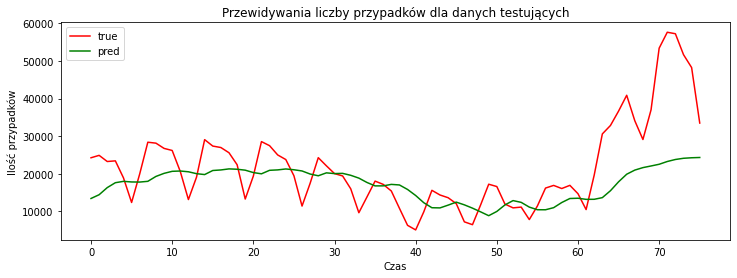

Błąd średniokwadratowy: 313449100.0
Średni błąd bezwzględny: 17185.727
Coefficient of determination: 0.17573792
Index of agreement: 0.5716698
Specyficzność: 0.71708995
Czułość: 0.0


In [11]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=8)
#print(tscv)

for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], "r--")
plt.plot(history.history['val_loss'], "g--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.savefig('time_series_8_loss.png')
plt.show()

y_preds = prepare_preds(X_train)
draw_predictions(len(y_preds), y_train.reshape(len(y_preds)) * MAX_DATA, y_preds, "trenujących", "time_series_8_train.png")
y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących", "time_series_8_test.png")

y = np.reshape(y_test, len(y_test))
mse = mean_squared_error(K.constant(y), K.constant(y_preds))
mae = mean_absolute_error(K.constant(y), K.constant(y_preds))
print('Błąd średniokwadratowy: ' + str(K.get_value(mse)))
print('Średni błąd bezwzględny: ' + str(K.get_value(mae)))
y_preds = y_preds / MAX_DATA
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
spec = specificity_m(K.constant(y), K.constant(y_preds)) 
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Specyficzność: ' + str(K.get_value(spec)))
print('Czułość: ' + str(K.get_value(recall)))

**Ilość podziałów: 2**

Epoch 1/50
15/15 [==============================] - 2s 111ms/step - loss: 0.0177 - val_loss: 0.0297
Epoch 2/50
15/15 [==============================] - 2s 105ms/step - loss: 0.0093 - val_loss: 0.0188
Epoch 3/50
15/15 [==============================] - 2s 107ms/step - loss: 0.0067 - val_loss: 0.0171
Epoch 4/50
15/15 [==============================] - 2s 105ms/step - loss: 0.0054 - val_loss: 0.0148
Epoch 5/50
15/15 [==============================] - 2s 127ms/step - loss: 0.0050 - val_loss: 0.0138
Epoch 6/50
15/15 [==============================] - 2s 106ms/step - loss: 0.0049 - val_loss: 0.0137
Epoch 7/50
15/15 [==============================] - 2s 126ms/step - loss: 0.0045 - val_loss: 0.0141
Epoch 8/50
15/15 [==============================] - 2s 105ms/step - loss: 0.0044 - val_loss: 0.0159
Epoch 9/50
15/15 [==============================] - 2s 103ms/step - loss: 0.0045 - val_loss: 0.0128
Epoch 10/50
15/15 [==============================] - 2s 102ms/step - loss: 0.0044 - val_loss: 0.0119

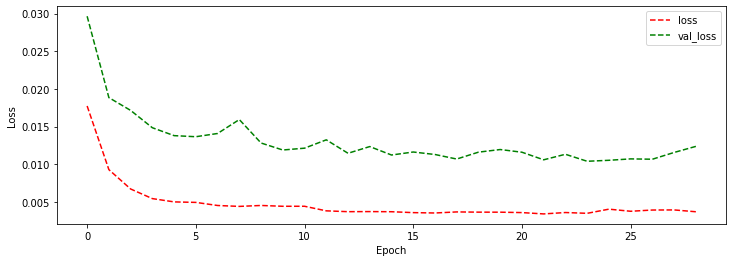

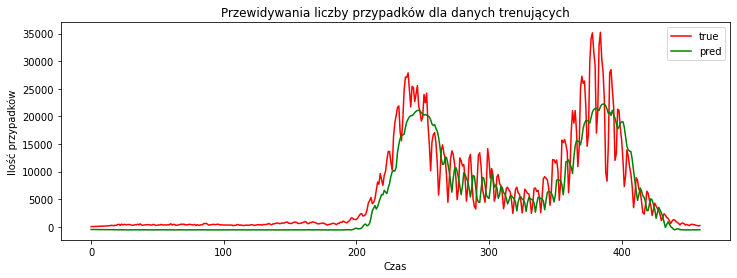

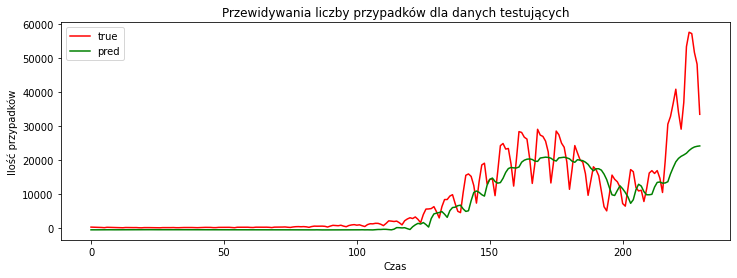

Błąd średniokwadratowy: 109354344.0
Średni błąd bezwzględny: 6768.4946
Coefficient of determination: 0.70633435
Index of agreement: 0.89581066
Specyficzność: 0.92328894
Czułość: 0.0


In [12]:
X, y = prepare_X_y(train_data)

tscv = TimeSeriesSplit(n_splits=2)
#print(tscv)

for train_index, test_index in tscv.split(X):
  #print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

model = ModelTrunk()

model.compile(optimizer='adam',
              loss=[MeanSquaredError(), MeanAbsoluteError()],
              run_eagerly=True)

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=5,
                          verbose=1)

callbacks = [EarlyStop]

history = model.fit(X_train, y_train, 
                    epochs=50, verbose=1,
                    validation_data = (X_test, y_test),
                    callbacks = callbacks
                   )

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], "r--")
plt.plot(history.history['val_loss'], "g--")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='best')
plt.savefig('time_series_2_loss.png')
plt.show()

y_preds = prepare_preds(X_train)
draw_predictions(len(y_preds), y_train.reshape(len(y_preds)) * MAX_DATA, y_preds, "trenujących", "time_series_2_train.png")
y_preds = prepare_preds(X_test)
draw_predictions(len(y_preds), y_test.reshape(len(y_preds)) * MAX_DATA, y_preds, "testujących", "time_series_2_test.png")

y = np.reshape(y_test, len(y_test))
mse = mean_squared_error(K.constant(y), K.constant(y_preds))
mae = mean_absolute_error(K.constant(y), K.constant(y_preds))
print('Błąd średniokwadratowy: ' + str(K.get_value(mse)))
print('Średni błąd bezwzględny: ' + str(K.get_value(mae)))
y_preds = y_preds / MAX_DATA
coeff = det_coeff(K.constant(y), K.constant(y_preds))
index = idx_of_agreement(K.constant(y), K.constant(y_preds))
recall = recall_m(K.constant(y), K.constant(y_preds))
spec = specificity_m(K.constant(y), K.constant(y_preds)) 
print('Coefficient of determination: ' + str(K.get_value(coeff)))
print('Index of agreement: ' + str(K.get_value(index)))
print('Specyficzność: ' + str(K.get_value(spec)))
print('Czułość: ' + str(K.get_value(recall)))